In [1]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
from astropy.io import fits

## Reading the Files

### Broad Band

In [48]:
#Observation 
result_b_1 = fits.open('acisf10849_000N022_r0009b_lc3.fits')
print(result_b_1.info())
resolution_b_1 = result_b_1[1].header['TIMEDEL']
print(f'Time resolution_1 = {resolution_b_1} s')
date_start_1 = result_b_1[1].header['DATE-OBS']
date_end_1 = result_b_1[1].header['DATE-END']
print(f'Observation Timeline : {date_start_1} to {date_end_1}\n\n')

Filename: acisf10849_000N022_r0009b_lc3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    163   519R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    169   519R x 5C   [1D, 1D, 1D, 1D, 1D]   
None
Time resolution_1 = 31.089788258076 s
Observation Timeline : 2009-01-02T21:25:57 to 2009-01-03T02:21:04




## Extracting the Data

In [49]:
%matplotlib inline
#OBSERVATION 1
lc_b_1 = result_b_1[1].data #Lightcurve
bg_b_1 = result_b_1[2].data #Lightcurve

#arrays
time_b_1 = lc_b_1['Time']
count_rate_b_1 = lc_b_1['COUNT_RATE']
count_rate_err_b_1 = lc_b_1['COUNT_RATE_ERR']

bg_count_rate_b_1 = bg_b_1['COUNT_RATE']
bg_count_rate_err_b_1 = bg_b_1['COUNT_RATE_ERR']

net_count_rate_b_1 = count_rate_b_1 - bg_count_rate_b_1
net_err_b_1 = [(count_rate_err_b_1[i]**2 + bg_count_rate_err_b_1[i]**2)**0.5 for i in range(len(bg_count_rate_b_1))]

#starting time from zero
dt_b_1 = time_b_1 - time_b_1[0]

## Representing the Data

### Broad Band

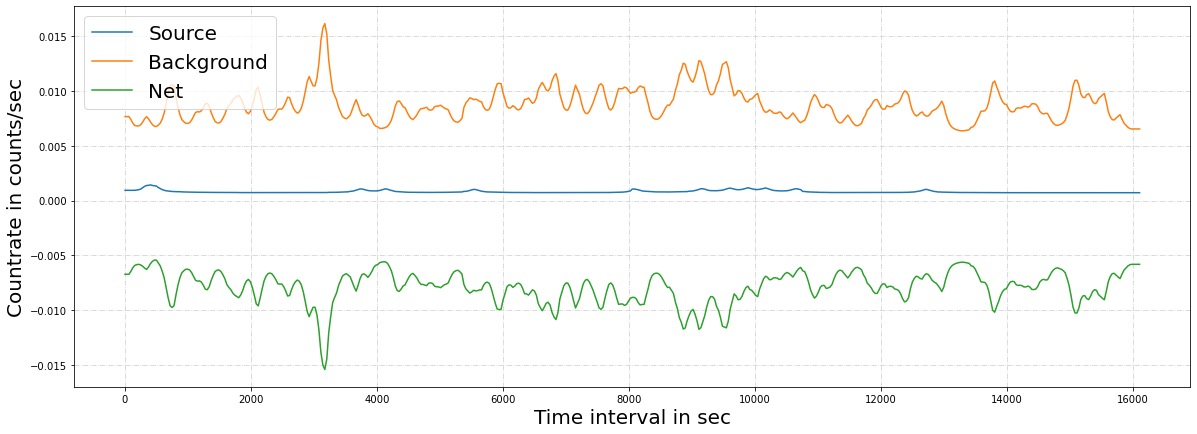

In [50]:
plt.figure(figsize = [20,7], facecolor = 'w')
plt.plot(dt_b_1, count_rate_b_1, label = 'Source')
plt.plot(dt_b_1, bg_count_rate_b_1, label = 'Background')
plt.plot(dt_b_1, net_count_rate_b_1, label = 'Net')
#plt.errorbar(dt_b_1,count_rate_b_1, count_rate_err_b_1)
plt.grid(color = 'lightgrey', ls = '-.')
plt.xlabel('Time interval in sec', fontsize = 20)
plt.ylabel('Countrate in counts/sec', fontsize =20)
#plt.title(f'plot of {file_name}', fontsize = 20)
#plt.text(10000,2.8e-5, s = f'resolution = {resolution} s', fontsize = 20)
#plt.xlim(0,40000)
#plt.ylim(0,0.0009)
plt.legend(fontsize = 20)

## Binning the Data


In [19]:
n_total_b_1 = 2243 #Total data points
n_bin_b_1 = 118 #Number of bins
bin_size_b_1 = int(n_total_b_1/n_bin_b_1) #Bin size in units of data points
binned_resolution_b_1 = bin_size_b_1*resolution_b_1
print(f'Binned resolution is {binned_resolution_b_1}s')

cr_binned_b_1= np.zeros(n_bin_b_1)
t_binned_b_1= np.zeros(n_bin_b_1)
err_binned_b_1 = np.zeros(n_bin_b_1)

for i in range(n_bin_b_1):
    t_binned_b_1[i] = dt_b_1[bin_size_b_1*i]
for i in range(n_bin_b_1):
    sum_err_sq = 0
    for j in range((bin_size_b_1)):
        #summing and averaging all the counts 
        cr_binned_b_1[i] += net_count_rate_b_1[j+i*bin_size_b_1]/bin_size_b_1
        #summing square errors
        sum_err_sq += net_err_b_1[j+i*bin_size_b_1]**2 
    err_binned_b_1[i] = (sum_err_sq/bin_size_b_1**2)**0.5 

#Percentage error before and after binning
err_percent_binned_b_1 = []
err_percent_b_1 = []
for i in range(n_bin_b_1):
    err_percent_binned_b_1.append((err_binned_b_1[i]/cr_binned_b_1[i])*100)
for i in range(n_total_b_1):
    err_percent_b_1.append((net_err_b_1[i]/net_count_rate_b_1[i])*100)
    
plt.figure(figsize = [20,7], facecolor = 'w')
plt.scatter(t_binned_b_1,cr_binned_b_1,c='green')
plt.errorbar(t_binned_b_1, cr_binned_b_1, err_binned_b_1,fmt = '.')
plt.title('Binned Lightcurve(Observation 1)', fontsize = 20)
plt.ylabel('x(ct/s)', fontsize = 20)
plt.figure(figsize = [20,4], facecolor = 'w')
plt.scatter(t_binned_b_1,err_percent_binned_b_1, label = 'After binning')
plt.scatter(dt_b_1[:n_total_b_1],err_percent_b_1, label = 'Before binning')
#plt.ylim(9.3,11)
plt.ylabel('%-age error in x', fontsize = 20)
plt.xlabel('Time in seconds', fontsize = 20)
plt.legend(fontsize = 20)

Binned resolution is 317.225142300121s


IndexError: index 1311 is out of bounds for axis 0 with size 1296

## Statistics from the Data

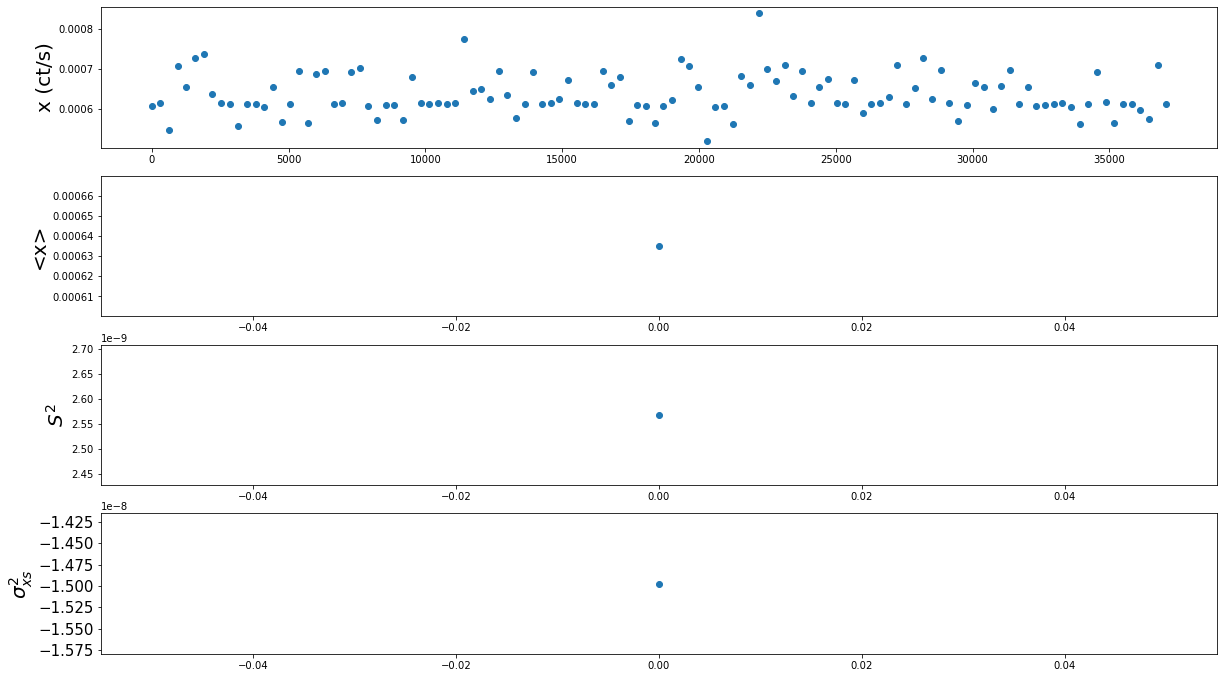

In [37]:
#MAKING AVG FLUX OF EVERY 20 POINTS
n_binned = 118#Total data points(already binned)
bin_size = 118#size of the bin in data points
n_points = int(n_binned/bin_size) #no. of data points

#print(n_points)
t_avg = [] #time for avg count of 20
c_avg = [] #avg count rate on 20 points bin
for i in range(n_points):
    t_avg.append(t_binned_b_1[i*bin_size])
    #print(i,i*25)
    sum = 0
    for j in range(bin_size):
        sum += cr_binned_b_1[j+i*bin_size]
    c_avg.append(sum/bin_size)
    
var = [] #variance
xs_var = [] #excess variance
for i in range(n_points):
    sum = 0
    sum_err_sq = 0 #sum of squared err
    for j in range(0,bin_size):
        sum += (cr_binned_b_1[j+i*bin_size] - c_avg[i])**2
        sum_err_sq += (err_binned_b_1[j+i*bin_size])**2
    avg_sum_err_sq = sum_err_sq/bin_size
    #print('err ',avg_sum_err_sq)
    #print('var ',sum/19)
    var.append(sum/(bin_size - 1))
    xs_var.append(var[i] - avg_sum_err_sq)

#EXPECTATION VALUE OF VARIANCE
'''
expect_var = []
t_further = []
for i in range(7):
    sum = 0
    t_further.append(t_avg[i*20])
    for j in range(20):
        sum += var[j+i*20]
    expect_var.append(sum/20)
'''    
#PLOTTING
plt.figure(figsize = [20,15])
ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax1.scatter(t_binned_b_1, cr_binned_b_1)
ax1.set_ylabel('x (ct/s)', fontsize = 20)
ax2.scatter(t_avg, c_avg)
ax2.set_ylabel('<x>', fontsize = 20)
ax3.scatter(t_avg, var)
ax3.set_ylabel('$S^2$', fontsize = 20)
y = plt.yticks(fontsize = 15)
#ax3.set_yscale('log')
ax4.scatter(t_avg, xs_var)
ax4.set_ylabel('$σ_{xs}^2$', fontsize = 20)
y = plt.yticks(fontsize = 15)
#ax4.set_yscale('log')

## Histogram of count rate


### Observation 3


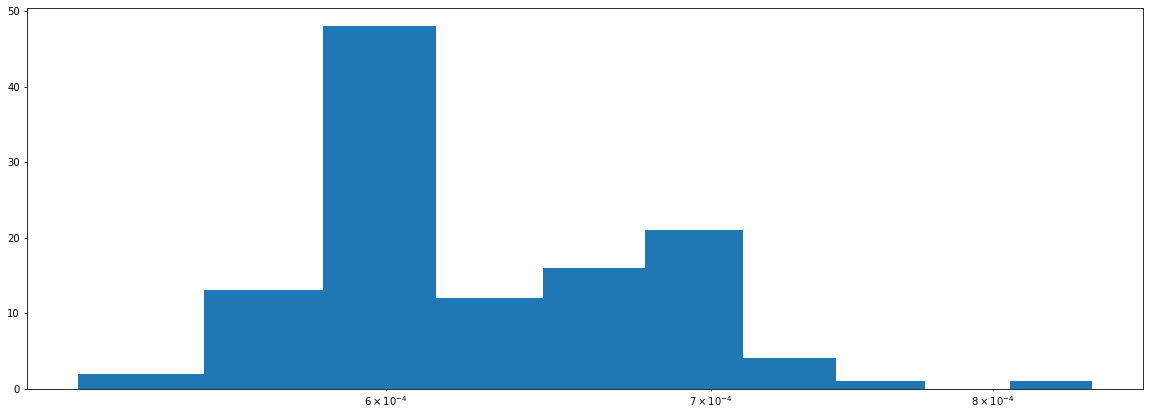

In [38]:
plt.figure(figsize = [20,7])
plt.hist(cr_binned_b_1, bins = 10)
plt.xscale('log')

## PSD using FFT from np.fft

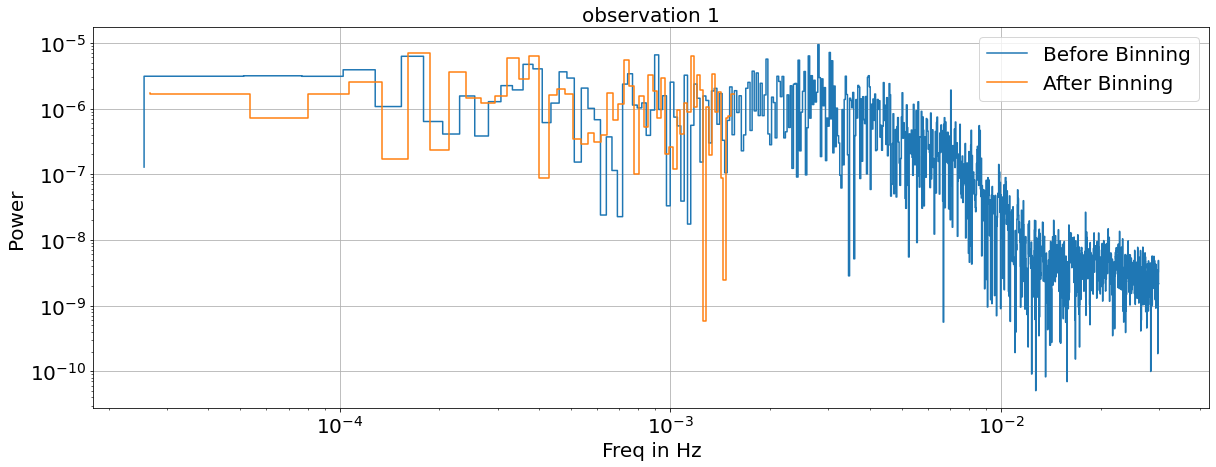

In [39]:
#Before Binning
fft_amp = abs(fft(count_rate_b_1))
n_tot = len(count_rate_b_1)
freq = [i/(n_tot*resolution_b_1) for i in range(1,int(n_tot/2))] #freq starting from 1/delT 

amp = fft_amp[1:int(n_tot/2)]/n_tot # Normalized amplitude only for positive frequencies
power = []
for i in range(len(amp)):
    power.append(2*n_tot*resolution_b_1*amp[i]**2)


#After Binning
fft_amp_bin = abs(fft(cr_binned_b_1))
n_binned = len(cr_binned_b_1)
freq_bin = [i/(n_binned*binned_resolution_b_1) for i in range(1,int(n_binned/2))] #freq starting from 1/delT 

amp_bin = fft_amp_bin[1:int(n_binned/2)]/n_binned #Normalized amplitude only for positive frequencies
power_bin = []
for i in range(len(amp_bin)):
    power_bin.append(2*n_binned*binned_resolution_b_1*amp_bin[i]**2)


plt.figure(figsize = [20,7], facecolor = 'w')
plt.step(freq,power, label = 'Before Binning')
plt.step(freq_bin,power_bin, label = 'After Binning')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 20)
plt.title('observation 1', fontsize = 20)
plt.xlabel('Freq in Hz', fontsize = 20)
plt.ylabel('Power', fontsize = 20)
plt.grid(True)
x=plt.xticks(fontsize = 20)
y=plt.yticks(fontsize = 20)